In [1]:
import ROOT

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

Welcome to JupyROOT 6.28/04


In [2]:
a = { "1" : 18.8, "2" : 13 }
b = { "1" : 0.86, "2" : 1.12 }

MevToKev = 1e3
FWHMToSigma = 1 / 2.633

def get_reso( energy, key ):
    return np.sqrt( a[key] + b[key] * energy ) * FWHMToSigma

In [3]:
for file in glob("sim/*.root"):

    name = file.split( "/" )[1].split( "." )[0]

    events = { "Energy1" : [], "Energy2" : [] }

    f1 = ROOT.TFile( file )

    t1 = f1.Get( "EdepLaBr1" )
    t2 = f1.Get( "EdepLaBr2" )

    for idx in tqdm( range( t1.GetEntries( ) ) ):

        t1.GetEntry( idx )
        t2.GetEntry( idx )

        energy1 = getattr( t1, "LaBr1" ) * MevToKev
        energy2 = getattr( t2, "LaBr2" ) * MevToKev

        if( energy1 > 0 ): energy1 = np.random.normal( energy1, get_reso( energy1, "1" ) )
        if( energy2 > 0 ): energy2 = np.random.normal( energy2, get_reso( energy2, "2" ) )

        events["Energy1"].append( energy1 )
        events["Energy2"].append( energy2 )

    df = pd.DataFrame( events )
    df.to_pickle( "processed/{}.pkl".format(name) )

100%|██████████| 1000000/1000000 [00:02<00:00, 339336.31it/s]


15o 10


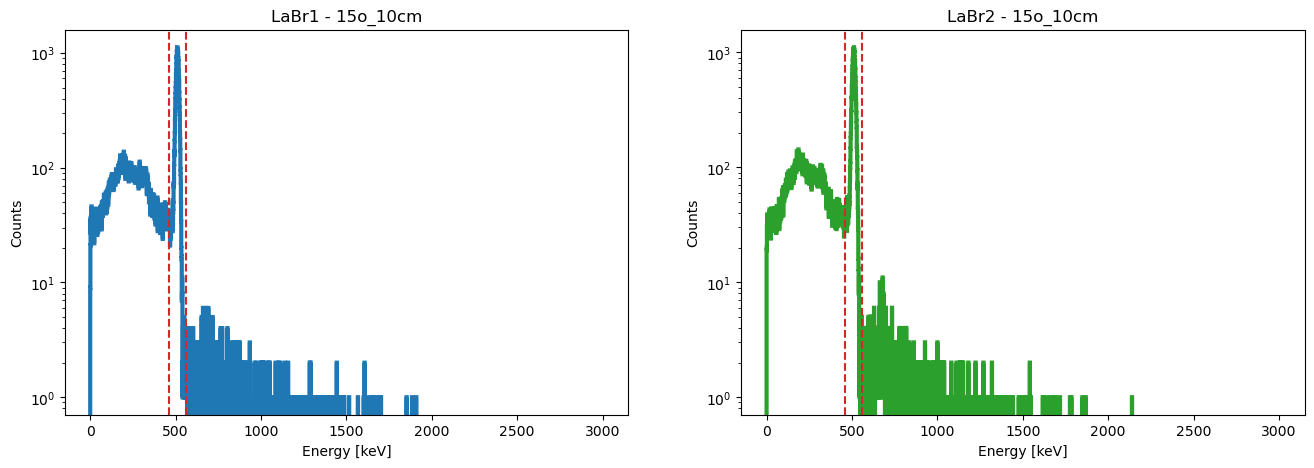

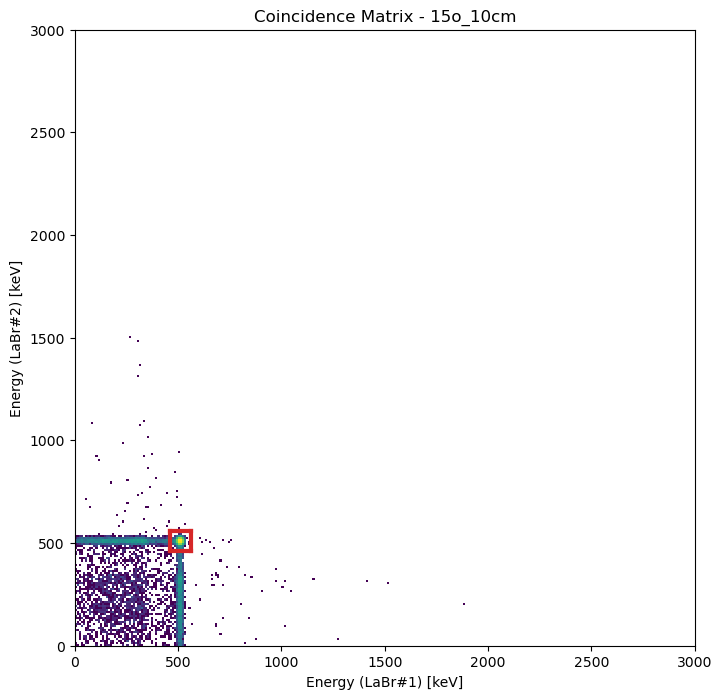

22na 10


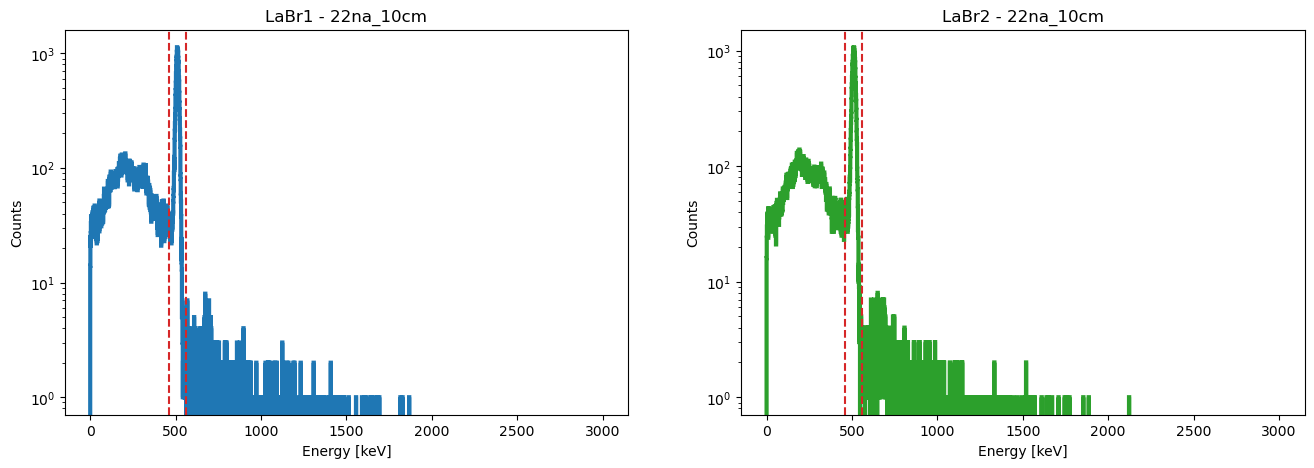

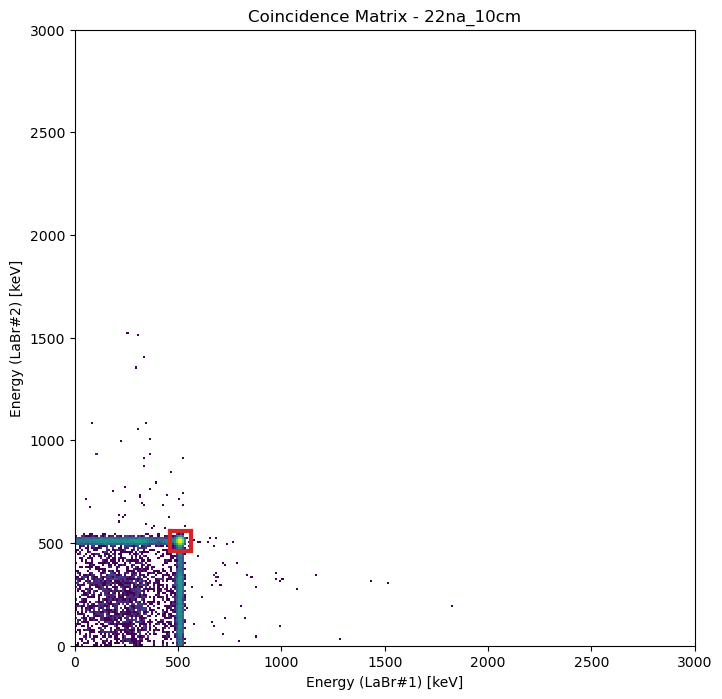

In [6]:
roi_min = 460
roi_max = 560

for file in glob("processed/*.pkl"):

    source = file.split( "/" )[1].split( "." )[0].split( "_" )[0]
    distance = file.split( "/" )[1].split( "." )[0].split( "_" )[1].split( "cm" )[0]
    
    df = pd.read_pickle( file )

    mask1 = ( df["Energy1"] > 0 )
    mask2 = ( df["Energy2"] > 0 )

    # Plot histogram of LaBr1 and LaBr2
    fig, ax = plt.subplots( 1, 2, figsize=( 16, 5 ) )

    ax[0].hist( df["Energy1"][mask1], bins=3000, histtype="step", color="tab:blue", label="LaBr1", range=(0, 3000), lw=3 )
    ax[1].hist( df["Energy2"][mask2], bins=3000, histtype="step", color="tab:green", label="LaBr2", range=(0, 3000), lw=3 )

    ax[0].set_xlabel( "Energy [keV]" )
    ax[1].set_xlabel( "Energy [keV]" )

    ax[0].set_ylabel( "Counts" )
    ax[1].set_ylabel( "Counts" )

    ax[0].set_yscale( "log" )
    ax[1].set_yscale( "log" )

    ax[0].title.set_text( "LaBr1 - {} at {} cm".format( source, distance ) )
    ax[1].title.set_text( "LaBr2 - {} at {} cm".format( source, distance ) )

    ax[0].axvline( roi_min, color="tab:red", linestyle="--" )
    ax[0].axvline( roi_max, color="tab:red", linestyle="--" )
    ax[1].axvline( roi_min, color="tab:red", linestyle="--" )
    ax[1].axvline( roi_max, color="tab:red", linestyle="--" )

    plt.savefig( "plots/{}_{}cm.png".format( source, distance )

    plt.show( )

    # Plot the 2D histogram when energy1 and energy2 are both > 0
    mask = mask1 & mask2

    fig, ax = plt.subplots( 1, 1, figsize=( 8, 8 ) )

    ax.hist2d( df["Energy1"][mask], df["Energy2"][mask], bins=300, range=[(0, 3000), (0, 3000)], cmap="viridis", norm=mpl.colors.LogNorm( ) )
    ax.plot( [roi_min, roi_min], [roi_min, roi_max], color="tab:red", linestyle="-", lw=3 )
    ax.plot( [roi_max, roi_max], [roi_min, roi_max], color="tab:red", linestyle="-", lw=3 )
    ax.plot( [roi_min, roi_max], [roi_min, roi_min], color="tab:red", linestyle="-", lw=3 )
    ax.plot( [roi_min, roi_max], [roi_max, roi_max], color="tab:red", linestyle="-", lw=3 )

    ax.set_xlabel( "Energy (LaBr#1) [keV]" )
    ax.set_ylabel( "Energy (LaBr#2) [keV]" )

    ax.title.set_text( "Coincidence Matrix - {} at {} cm".format( source, distance  ) )

    plt.savefig( "plots/2D_{}_{}cm.png".format( source, distance ) )
    plt.show( )

    mask1 = ( df["Energy1"] > roi_min ) & ( df["Energy1"] < roi_max )
    mask2 = ( df["Energy2"] > roi_min ) & ( df["Energy2"] < roi_max )
    mask = mask1 & mask2

    counts = len( df[mask] )

    with open( "results/eff.txt", "a" ) as f:
        f.write( "{} {}\n".format( file.split( "/" )[1].split( "." )[0], counts / 1e6 ) )
